In [1]:
import os
import datetime as dt
from datetime import datetime, timedelta
import time
import sqlite3
import re
import math
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
plt.style.use('fivethirtyeight')
#mpl.rcParams['figure.figsize'] = (12.0, 6.0)
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
##Pull and format the time accordingly
##The original timestamp from Google Chrome is formatted as the number of microseconds 
##since Jan 1601

def get_time(time, kind):
    time = int(time)
    cdate1 = dt.datetime(1601,1,1)
    cdate2 = dt.timedelta(microseconds=time)
    joined = cdate1+cdate2
    return joined.strftime(kind)

def adjusted_time(hr):
    hr = int(hr)
    hr = hr - 6
    #ampm = ('am' if (0 <= int(time) < 12) else 'pm')
    h = math.floor(hr) % 24
    #if h == 0:
    #    h = 12
    #return "%d:%02d%s" % (h, int(time % 1 * 60), ampm)
    return int(h)

def new_adjusted_time(rawtime):
    hr = int(rawtime.split(':')[0])
    minute = float(rawtime.split(':')[1]) * 100 / 6000
    #minute = float("{0:.2f}".format(minute))
    a_time = (hr+minute) - 6
    return float("{0:.2f}".format(a_time % 24))

In [3]:
##The Chrome history file uses a SQLite database format
##Pull desired information using query + regex

fakehistory='~/Library/Application Support/Google/Chrome/Default/fakehistory'

def pull_history(file_loc):
    
    filename = os.path.expanduser(file_loc)
    conn = sqlite3.connect(filename)
    c = conn.cursor()
    
    URLS_prep, URLS, fulltime, day_of_visit, time_of_visit, duration = ([] for i in xrange(6))
    
    pattern = r'://.*[\.\:]\w*/|:///.*/'
    
    for info in c.execute('SELECT urls.url, visit_time, visit_duration FROM visits, urls WHERE visits.url=urls.id;'):
        url = re.findall(pattern, info[0])
        URLS_prep.extend(url)
        
        #Get full timestamp
        timestamp = get_time(info[1], '%B %d, %Y')
        fulltime.append(timestamp)
        
        #Get day of visit
        day = get_time(info[1], '%A')
        day_of_visit.append(day)
        
        #Get time of visit
        time = get_time(info[1], '%H')
        time = adjusted_time(time)
        #time = adjusted_time(time)
        time_of_visit.append(int(time))
        
        #Get duration of visit
        dura = info[2]
        #dura = time.strftime("%H:%M:%S", time.gmtime(dura))
        duration.append(dura)
        
    #Get URL
    for u in URLS_prep:
        u = str(u[3:-1])
        URLS.append(u)
        
    return URLS, fulltime, day_of_visit, time_of_visit, duration

In [4]:
##Put data into a Pandas dataframe

def clean_table():
    URLS, fulltime, day, time, duration = pull_history(fakehistory)
    n_duration = []
    df=pd.DataFrame(URLS,columns=['URL'])
    df['timestamp'] = fulltime
    df['day'] = day
    df['time'] = time
    df['freq'] = df.groupby('URL')['URL'].transform('count')
    df['freq_time'] = df.groupby('time')['time'].transform('count')
    df['duration'] = duration
    #clean data
    df = df[df.duration != 0]
    df = df[df.freq > 3]
    countdf = df.groupby('URL').count()
    df = df.reset_index(drop=True)
    
    return df

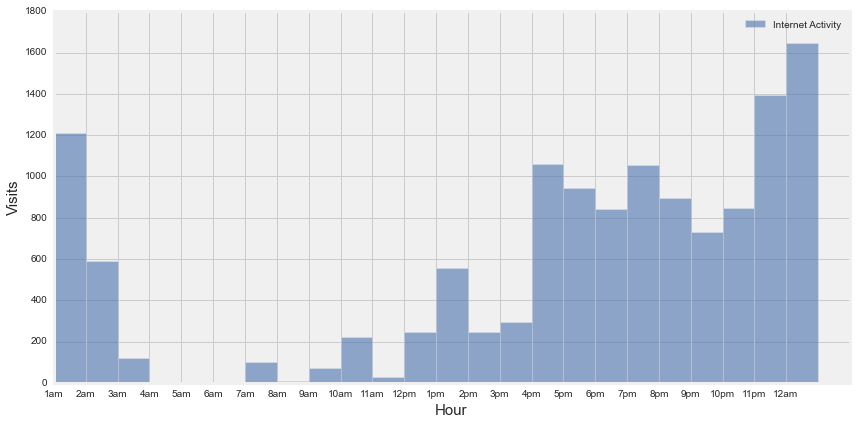

In [5]:
##Graph an overall summary of [time of visit] vs. [internet activity] (amount of different sites visited)

times = np.arange(24)
labels = [
    '12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', 
  '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm' 
]
labels = np.roll(labels, -1)
plt.rcParams['figure.figsize']=(12,6)
####
activity = clean_table()
activity = activity[['time', 'freq_time']]
for x in xrange(0,24):
    if x not in (t for t in activity.time):
        activity.loc[len(activity)]=[x,0] 
activity = activity.sort('time', ascending = True)
activity = activity.drop_duplicates().reset_index(drop=True)
####
a = plt.bar(times, activity.freq_time, width=1, alpha=0.6, label='Internet Activity')
plt.xticks(times[::1], labels[::1], rotation='horizontal')
plt.ylabel('Visits', size = 15)
plt.xlabel('Hour', size = 15)

plt.legend()
plt.tight_layout()
plt.savefig('histogram.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

In [6]:
##Preparation for graph depicting weekday vs weekend internet activity

def split_days(everyday, typeofday):
    wwday = everyday.loc[everyday['day'].isin(typeofday)]
    wwday['freq_time'] = wwday.groupby('time')['time'].transform('count')
    wwday = wwday[['time', 'freq_time']]
    wwday = wwday.drop_duplicates()
    for x in xrange(0,24):
        if x not in (t for t in wwday.time):
            wwday.loc[len(weekend)]=[x,0] 
    wwday = wwday.sort('time', ascending = True)
    wwday = wwday[['freq_time']].reset_index(drop=True)
    
    return wwday

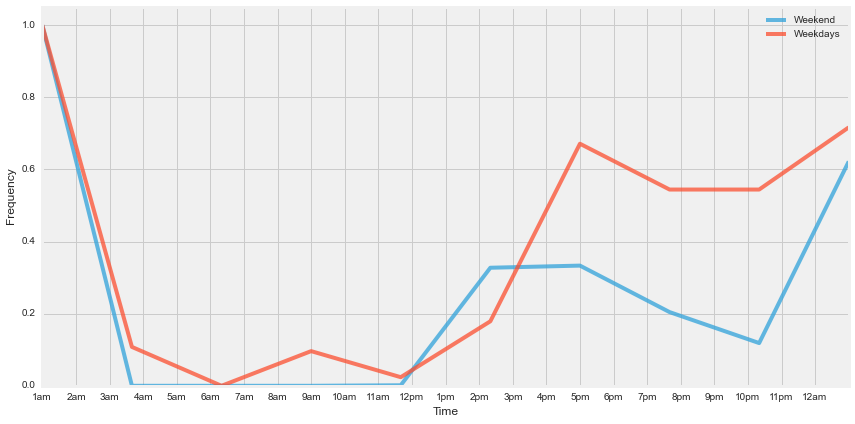

In [7]:
## Visualize weekday vs weekend internet activity using spline to fit a curve.
## Because weekdays have much more visits, modified curves to be based 
## on frequency instead of count in order to see the distinctions more easily

from scipy.interpolate import InterpolatedUnivariateSpline
x_norm = np.linspace(0, 23, num=10, endpoint=True)
x_spline = np.linspace(0, 24, num=10, endpoint=True)
alldays = clean_table()
ends = ['Saturday', 'Sunday']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

weekend = split_days(alldays, ends)
spline = InterpolatedUnivariateSpline(times+.5, weekend, k=1)
smax = spline(x_norm).max()
smin = spline(x_norm).min()
splines = ((spline(x_spline) - smin) / (smax - smin))
plt.plot(x_spline, splines, '-', alpha=0.75, label='Weekend')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.xlim([0,24])
plt.xticks(times[::1], labels[::1], rotation='horizontal')
plt.ylim([0,1.05])

weekdays = split_days(alldays, days)
spline2 = InterpolatedUnivariateSpline(times+.5, weekdays, k=1)
smax = spline2(x_norm).max()
smin = spline2(x_norm).min()
splines2 = ((spline2(x_spline) - smin) / (smax - smin))
plt.plot(x_spline, splines2, '-', alpha=0.75, label='Weekdays')

plt.legend()
plt.tight_layout()
plt.savefig('weekendornah.png', bbox_inches='tight', pad_inches=0.2, dpi=500)
plt.show()

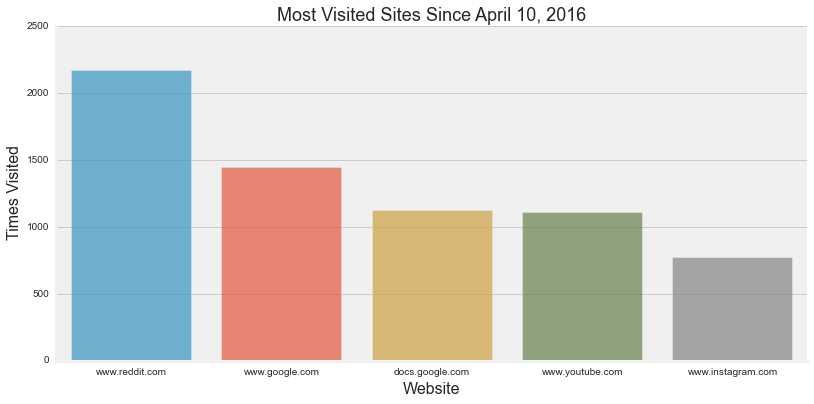

In [8]:
## Make/modify df for top visited sites

df = clean_table()
df = df[['URL', 'freq']]
df = df.drop_duplicates()
df = df.sort('freq', ascending = False)
df = df.reset_index(drop=True)

## pick any number
df = df.head(5)

##Graph top (5) visited sites

plt.rcParams['figure.figsize']=(12,6)
ax = sns.barplot(x ='URL',y="freq",data=df, alpha = 0.75)
ax.set_xlabel('Website', size = 16)
ax.set_ylabel('Times Visited', size = 16)
ax.set_title("Most Visited Sites Since "+min(fulltime), size = 18)
sns.despine(right=True)

plt.savefig('Top5 Sites.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

In [9]:
##Options for choosing history from n weeks ago 

def weeks_ago(weeks):
    past = []
    now = datetime.now()
    
    for n in xrange((weeks*7)-7,weeks*7):
        past_days = now-timedelta(days=n+1)
        past_days = past_days.strftime("%B %d, %Y")
        past.append(past_days)

    return past